In [1]:
"""
``autoreload`` is an IPython extension that reloads modules
automatically before executing the line of code typed.
"""

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")


In [3]:
RAW_DATA_PATH = Path('__file__').absolute().parents[1] / 'data' / '01_raw'
PROCESSED_DATA_PATH = Path('__file__').absolute().parents[1] / 'data' / '02_processed'
RAW_DATA_PATH

WindowsPath('c:/Users/Lyndon/Documents/University/CS3AM/coursework/CS3AM-COURSEWORK/data/01_raw')

In [4]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = [15, 8]

In [5]:
sns.set_style('whitegrid')

In [6]:
df = pd.read_csv('../data/02_processed/AAPL_processed.csv')
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
0,1981-01-02,0.118602,0.154018,0.155134,0.154018,0.154018,21660800,AAPL,0.010989,0.001289
1,1981-01-05,0.116024,0.150670,0.151228,0.150670,0.151228,35728000,AAPL,-0.021738,-0.002578
2,1981-01-06,0.110867,0.143973,0.144531,0.143973,0.144531,45158400,AAPL,-0.044448,-0.005157
3,1981-01-07,0.106140,0.137835,0.138393,0.137835,0.138393,55686400,AAPL,-0.042633,-0.004727
4,1981-01-08,0.103992,0.135045,0.135603,0.135045,0.135603,39827200,AAPL,-0.020241,-0.002148


In [12]:
model_inputs = df.set_index('Date')['Returns']

In [8]:
# model = auto_arima(model_inputs, start_P=1, start_Q=1, test='adf', max_P=7,max_Q=7, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
# print(model.summary())

In [13]:
def grid_search_arima(data):
    best_aic = float('inf')
    best_params = None
    
    # Define parameter grid
    p_values = range(0, 5)
    d_values = range(0, 3)
    q_values = range(0, 5)
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = auto_arima(data,
                                     start_p=p, max_p=p,
                                     start_d=d, max_d=d,
                                     start_q=q, max_q=q,
                                     seasonal=False,
                                     stepwise=False,
                                     suppress_warnings=True)
                    
                    if model.aic() < best_aic:
                        best_aic = model.aic()
                        best_params = (p, d, q)
                        
                except:
                    continue
    
    return best_params, best_aic


In [15]:
grid_search_arima(model_inputs)

((0, 1, 4), -47882.109928380465)

In [10]:
# # Example: Assume 'returns' is your predicted percentage changes
# # and 'adj_close' is your original adjusted close prices

# # Last known actual price
# last_known_price = df['Adj Close'].iloc[-1]

# # Predicted percentage changes (as fractions, not percentages)
# predicted_pct_changes = model.predict(n_periods=30)  # Example for 30 periods

# # Convert percentage changes back to actual price
# predicted_prices = [last_known_price]
# for pct_change in predicted_pct_changes:
#     new_price = predicted_prices[-1] * (1 + pct_change)
#     predicted_prices.append(new_price)

# # Remove the first element as it's just the last known price
# predicted_prices = predicted_prices[1:]

# # Convert to a pandas Series for convenience
# predicted_prices_series = pd.Series(predicted_prices, index=your_future_dates)

# print(predicted_prices_series)

In [11]:
plotting_values = df.set_index('Date')['Adj Close']


In [12]:
row = plotting_values['2018-01-02']
row

40.524345

In [ ]:
start_date = '2018-01-02'
end_date = '2024-11-14'

date_range = pd.date_range(start=start_date, end=end_date, freq='B')
n_periods = len(date_range)


forecast = model.predict(n_periods=n_periods)
forecast.index = date_range

last_known_price = plotting_values[start_date]

# Calculate predicted prices
predicted_prices = [last_known_price]
for pct_change in forecast:
    new_price = predicted_prices[-1] * (1 + pct_change)
    predicted_prices.append(new_price)

predicted_prices = np.array(predicted_prices[1:])


In [17]:
date_range

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15',
               ...
               '2024-11-01', '2024-11-04', '2024-11-05', '2024-11-06',
               '2024-11-07', '2024-11-08', '2024-11-11', '2024-11-12',
               '2024-11-13', '2024-11-14'],
              dtype='datetime64[ns]', length=1793, freq='B')

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(plotting_values.index, plotting_values, label='Actual')
plt.plot(forecast.index, predicted_prices, label='Forecast')
plt.title('Auto ARIMA Forecast')
plt.legend()
plt.show()

TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x000001B514317C10>.

Error in callback <function _draw_all_if_interactive at 0x000001B547EBC860> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [78]:
plotting_values

Date
1981-01-02      0.118602
1981-01-05      0.116024
1981-01-06      0.110867
1981-01-07      0.106140
1981-01-08      0.103992
                 ...    
2024-11-08    226.960000
2024-11-11    224.230000
2024-11-12    224.230000
2024-11-13    225.120000
2024-11-14    228.220000
Name: Adj Close, Length: 11061, dtype: float64

In [81]:
forecast

2018-01-02    0.000897
2018-01-03    0.000629
2018-01-04    0.000741
2018-01-05    0.001413
2018-01-08    0.001103
                ...   
2024-11-08    0.001079
2024-11-11    0.001079
2024-11-12    0.001079
2024-11-13    0.001079
2024-11-14    0.001079
Freq: B, Length: 1793, dtype: float64

In [80]:
len(predicted_prices)

1793

In [20]:
df

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
0,1981-01-02,0.118602,0.154018,0.155134,0.154018,0.154018,21660800,AAPL,0.010989,0.001289
1,1981-01-05,0.116024,0.150670,0.151228,0.150670,0.151228,35728000,AAPL,-0.021738,-0.002578
2,1981-01-06,0.110867,0.143973,0.144531,0.143973,0.144531,45158400,AAPL,-0.044448,-0.005157
3,1981-01-07,0.106140,0.137835,0.138393,0.137835,0.138393,55686400,AAPL,-0.042633,-0.004727
4,1981-01-08,0.103992,0.135045,0.135603,0.135045,0.135603,39827200,AAPL,-0.020241,-0.002148
...,...,...,...,...,...,...,...,...,...,...
11056,2024-11-08,226.960000,226.960000,228.660000,226.410000,227.170000,38328800,AAPL,-0.001188,-0.269989
11057,2024-11-11,224.230000,224.230000,225.700000,221.500000,225.000000,42005600,AAPL,-0.012029,-2.730011
11058,2024-11-12,224.230000,224.230000,225.590000,223.360000,224.550000,40398300,AAPL,0.000000,0.000000
11059,2024-11-13,225.120000,225.120000,226.650000,222.760000,224.010000,48566200,AAPL,0.003969,0.889999


In [12]:
# Make predictions on the test set
predictions = model.predict(n_periods=len(test))

# Calculate performance metrics
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = np.mean(np.abs((test - predictions) / test)) * 100
r2 = r2_score(test, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'R²: {r2}')

print(f'AIC: {model.aic()}')
print(f'BIC: {model.bic()}')


NameError: name 'test' is not defined

In [ ]:
# Generate in-sample predictions
in_sample_predictions = model.predict_in_sample()

# Generate out-of-sample forecasts with confidence intervals
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)


In [ ]:
target.index[0]

Timestamp('1980-12-15 00:00:00')

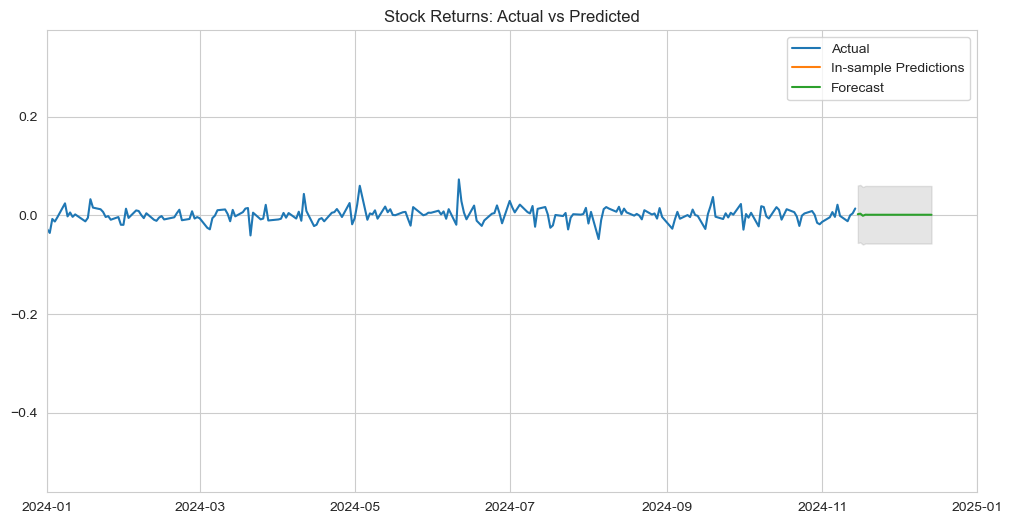

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(target_diff.index, target_diff, label='Actual')
plt.plot(target_diff.index[:len(in_sample_predictions)], in_sample_predictions, label='In-sample Predictions')
plt.plot(pd.date_range(start=target_diff.index[-1], periods=31, freq='D')[1:], forecast, label='Forecast')
plt.fill_between(pd.date_range(start=target_diff.index[-1], periods=31, freq='D')[1:],
                 conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2)
plt.title('Stock Returns: Actual vs Predicted')
plt.legend()
plt.xlim(pd.Timestamp('2024-01-01'), pd.Timestamp('2025-01-01'))
plt.show()